# Load candidates

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/anhphantq/otto')

In [3]:
CACHE = '/home/anhphantq/cache_train'
import os

import pickle
from tqdm import tqdm
train_data = []
num_cands = []

with open(CACHE + '/metadata', 'rb') as f:
  metadata = pickle.load(f)

num_frags = metadata['num_frags']


for i in tqdm(range(num_frags)):
    with open(CACHE + f'/train_data_{i}', 'rb') as f:
      data = pickle.load(f)
      train_data.extend(data[0])
      num_cands.extend(data[1])






100%|██████████| 90/90 [00:30<00:00,  2.93it/s]


In [4]:
import numpy as np
train_data = np.concatenate(train_data)
num_cands = np.concatenate(num_cands)
train_data.shape, num_cands.shape

((13207149, 23), (4402383,))

In [5]:
from xgb_utils import create_data

In [6]:
train_data.shape

(13207149, 23)

In [7]:
import pandas as pd 

candidates = create_data(train_data, infer = False)


In [8]:
del train_data

In [9]:
candidates


,user,item,fitness_sub,fitness_time_decay,fitness_num_appeareance,type,cofitness_cosub_mean,cofitness_cosub_var,cofitness_time_decay_mean,cofitness_time_decay_var,...,num_clicks,num_carts,num_orders,item_pr,prod_cofitness_cosub_cofitness_time_decay,prod_cofitness_cosub_num_appearance,prod_cofitness_time_decay_num_appearance,clicks,carts,orders
0,11258102,299587,133.028805,70.740193,19,0,3.332448,30.619445,1.057183,9.512867,...,282.0,116.0,73.0,5.330036e-07,9410.483344,2527.547294,1344.063668,1,0,0
1,11258102,1703866,121.880073,66.512263,19,0,3.332448,30.619445,1.057183,9.512867,...,204.0,98.0,65.0,4.265562e-07,8106.519452,2315.721392,1263.732992,1,0,0
2,11258102,867527,117.381833,59.040365,24,0,3.332448,30.619445,1.057183,9.512867,...,1054.0,160.0,85.0,1.660340e-06,6930.266312,2817.163997,1416.968767,1,0,0
3,11258102,545626,84.167550,46.756995,15,0,3.332448,30.619445,1.057183,9.512867,...,228.0,110.0,57.0,4.367616e-07,3935.421720,1262.513254,701.354924,1,0,0
4,11258102,1402620,80.917813,44.938608,15,0,3.332448,30.619445,1.057183,9.512867,...,185.0,91.0,56.0,3.434873e-07,3636.333884,1213.767193,674.079122,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13207144,11239204,1670764,0.162221,0.162221,1,2,0.133658,0.064625,0.031481,0.020741,...,826.0,83.0,16.0,1.167859e-06,0.026316,0.162221,0.162221,0,0,1
13207145,11239204,1687138,0.162221,0.162221,1,2,0.133658,0.064625,0.031481,0.020741,...,144.0,10.0,3.0,1.919042e-07,0.026316,0.162221,0.162221,0,0,1
13207146,11239204,1327857,0.204362,0.073431,1,2,0.133658,0.064625,0.031481,0.020741,...,7.0,0.0,0.0,2.337353e-08,0.015006,0.204362,0.073431,0,0,1
13207147,11239204,313080,0.142896,0.060737,1,2,0.133658,0.064625,0.031481,0.020741,...,2057.0,102.0,24.0,3.446954e-06,0.008679,0.142896,0.060737,0,0,1


# Train params

In [50]:
PARAMS = {
    'max_depth' : 5,
    'eta': 1,
    
}
N_SPLITS = 3
NUM_TREE = 100
MODEL_PATH = '/home/anhphantq/xgboost'
VERSION = '2'

# Train for each type

In [51]:
from xgb_utils import get_len_group

In [52]:
import pandas as pd 
import numpy as np
tar = pd.read_parquet('/home/anhphantq/otto/splitted_data/test_labels.parquet')
tar = tar.loc[(tar['session'] <= candidates['user'].max()) & (tar['session'] >= candidates['user'].min()) ]
aids = tar.ground_truth.explode().astype('int32').rename('item')
tar = tar[['session', 'type']].rename({'session':'user'},axis=1)
tar = tar.merge(aids, left_index=True, right_index=True, how='left')
tar['type'] = tar['type'].apply(lambda x: 0 if x == 'clicks' else 1 if x == 'carts' else 2)
tar['label'] = 1

In [53]:
tar

,user,type,item,label
113400,11188590,0,607328,1
113401,11188591,0,557157,1
113402,11188591,1,1597320,1
113402,11188591,1,1236555,1
113402,11188591,1,970284,1
...,...,...,...,...
225106,11278648,2,35621,1
225107,11278649,0,4094,1
225108,11278650,0,46367,1
225109,11278651,0,885446,1


In [54]:
import xgboost as xgb
from sklearn.model_selection import GroupKFold
import os
def train(tar_, candidates_, num_cands_, t, id_type):
  
  name = f'/{t}_only_'
  try:
    shutil.rmtree(MODEL_PATH + name + VERSION)
  except:
    pass
  else:
    print('remove all version')
  
  tar = tar_[tar_['type'] == id_type].copy()
  idx = candidates_['type'] == id_type
  candidates = candidates_[idx].copy()
  
  candidates['user_type'] = candidates['user'] * 10 + candidates['type']
  tar['user_type'] = tar['user'] * 10 + tar['type']
  del tar['type'], tar['user']
  candidates = candidates.merge(tar,on=['user_type','item'],how='left').fillna(0)
  candidates['label'] = candidates['label'].values.astype(np.int16)
  
  del candidates['type'], candidates['user_type']

  skf = GroupKFold(n_splits=N_SPLITS)
  for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates['label'], groups=candidates['user'] )):

      X_train = candidates.iloc[train_idx, 2 : -1]
      y_train = candidates.iloc[train_idx, -1]
      X_valid = candidates.iloc[valid_idx, 2 : -1]
      y_valid = candidates.iloc[valid_idx, -1]

      dtrain = xgb.DMatrix(X_train, y_train, nthread = os.cpu_count() ) 
      dtrain.set_group(get_len_group(train_idx, num_cands))
      dvalid = xgb.DMatrix(X_valid, y_valid, nthread = os.cpu_count() ) 
      dvalid.set_group(get_len_group(valid_idx, num_cands))
      
      xgb_parms = {'objective':'rank:pairwise', 'nthread' : os.cpu_count()
      , **PARAMS}
      model = xgb.train(xgb_parms, 
          dtrain=dtrain,
          evals=[(dtrain,'train'),(dvalid,'valid')],
          num_boost_round=NUM_TREE,
          early_stopping_rounds= 5,    
          verbose_eval=1)
      try:
        os.mkdir(MODEL_PATH + name + VERSION)
      except:
        pass
      model.save_model(MODEL_PATH + name + VERSION + f'/XGB_fold{fold}.xgb')
      xgb.plot_importance(model)

[15:21:39] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[0]	train-map:0.81283	valid-map:0.81669
[1]	train-map:0.81335	valid-map:0.81737
[2]	train-map:0.81379	valid-map:0.81788
[3]	train-map:0.81418	valid-map:0.81825
[4]	train-map:0.81454	valid-map:0.81828
[5]	train-map:0.81516	valid-map:0.81846
[6]	train-map:0.81560	valid-map:0.81846
[7]	train-map:0.81584	valid-map:0.81825
[8]	train-map:0.81603	valid-map:0.81820
[9]	train-map:0.81640	valid-map:0.81813
[10]	train-map:0.81648	valid-map:0.81816
[15:21:56] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[0]	train-map:0.81444	valid-map:0.81375
[1]	train-map:0.81509	valid-map:0.81427
[2]	train-map:0.81560	valid-map:0.81455
[3]	train-map:0.81618	valid-map:0.81457
[4]	train-map:0.81615	valid-map:0.81463
[5]	train-map:0.81664	valid-map:0.81471
[6]	train-map:0.81695	valid-map:0.81430
[7]	train-map:0.81705	valid-map:0.81429
[8]	train-map:0.81727	valid-map:0.81414
[9]	train-m

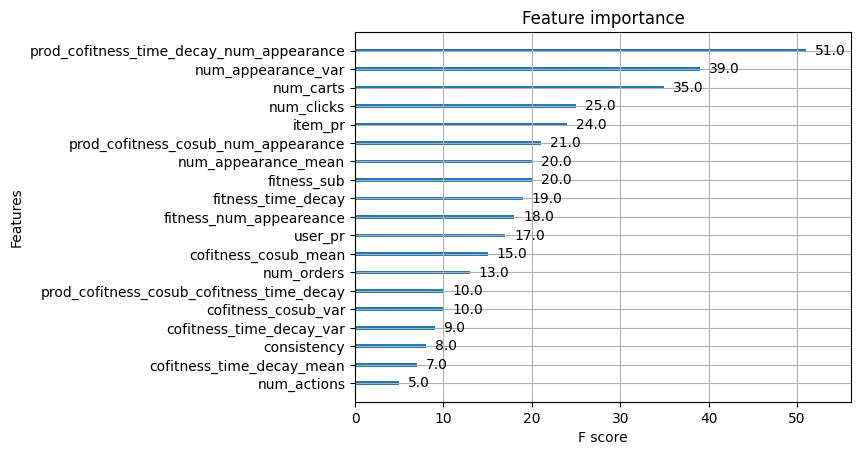

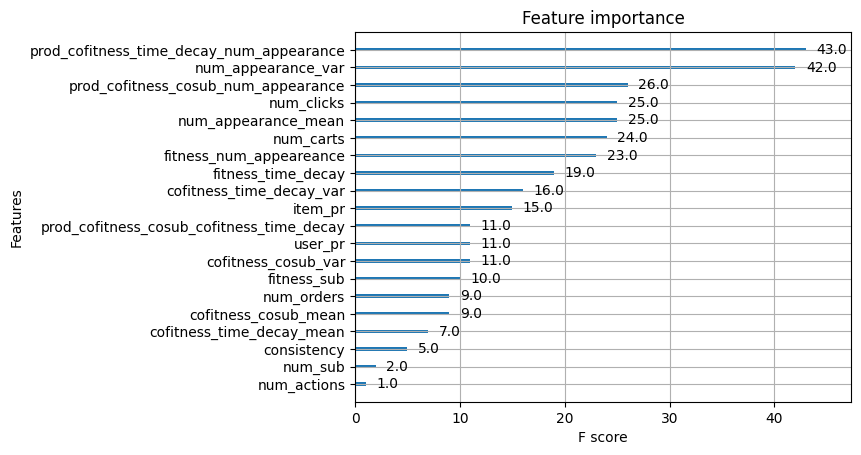

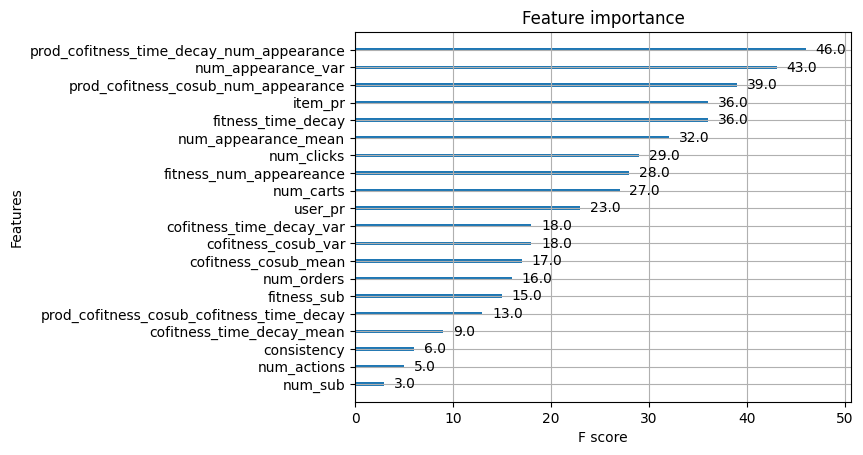

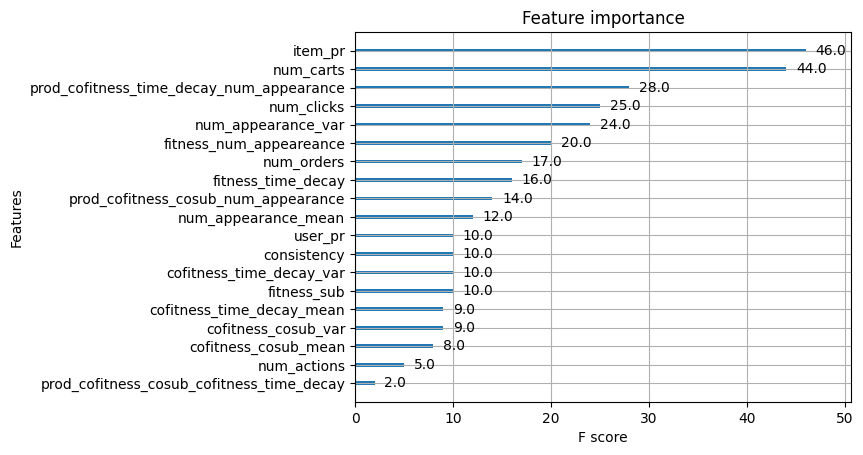

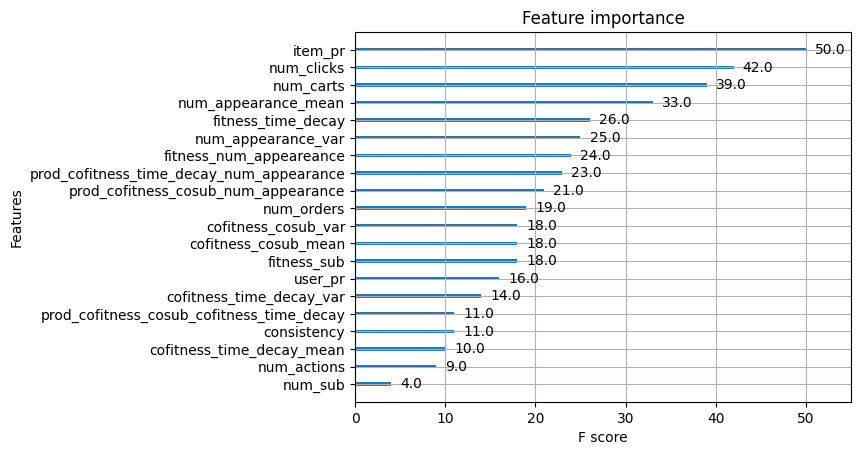

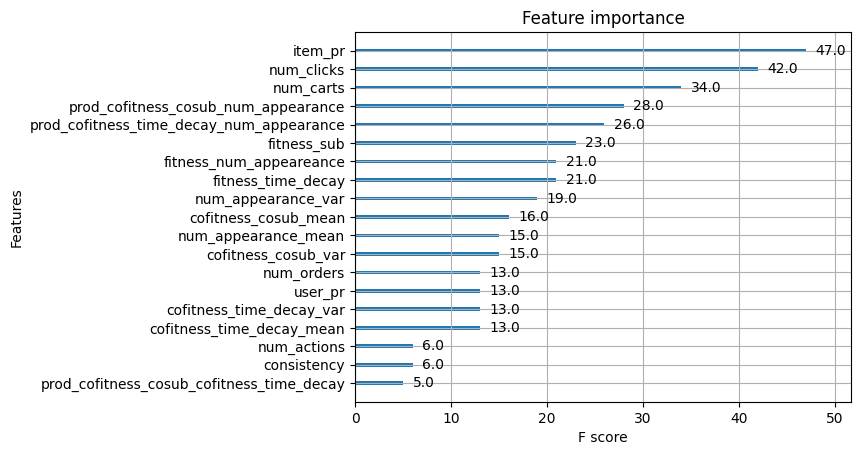

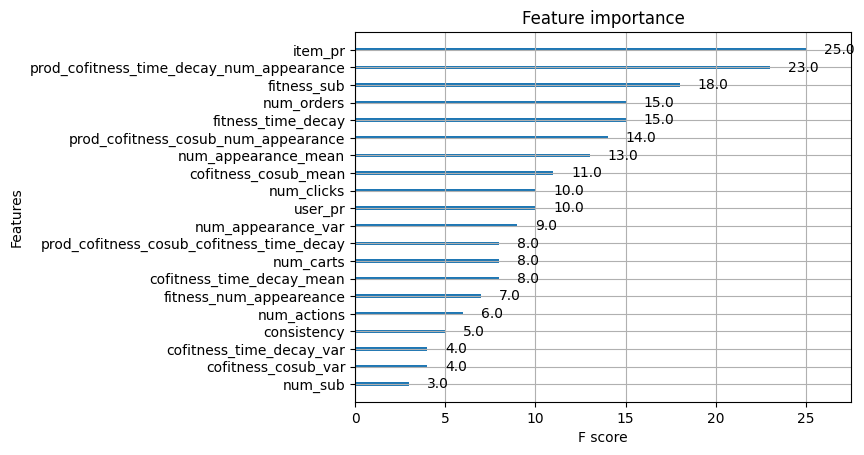

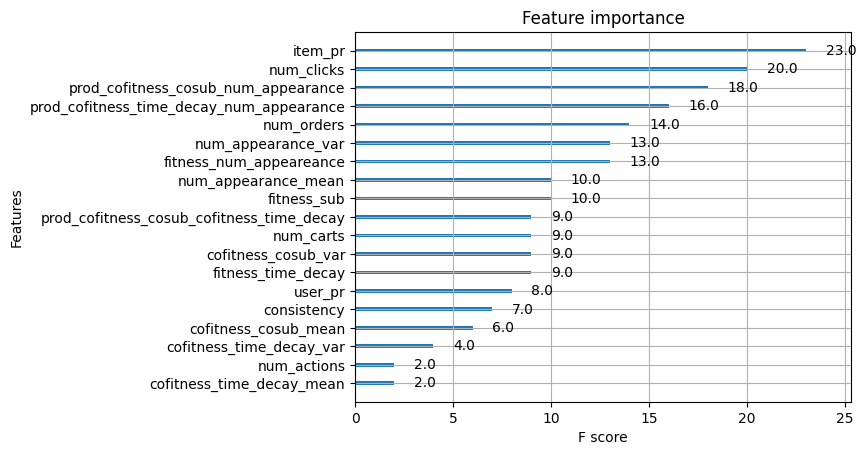

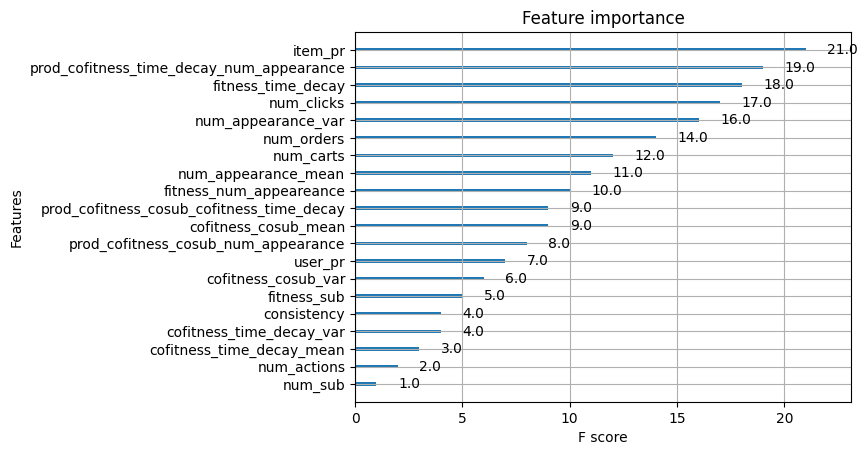

In [55]:
for id_type, t in enumerate(['clicks', 'carts', 'orders']):
  train(tar, candidates, num_cands, t, id_type)